In [73]:
import pandas as pd
import pylab as pl
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.metrics import confusion_matrix
%pylab inline

df = pd.read_csv('../data/sample_data.csv', sep=',', header=0, index_col=0)
print df.columns
df.head()

Populating the interactive namespace from numpy and matplotlib
Index([u'site_id', u'strategy_id', u'list_type', u'line_id', u'adv_id',
       u'adv_vertical', u'name', u'goal', u'price', u'limit', u'avg_bid',
       u'max_bid', u'impressions', u'conversions', u'avg_imps_site',
       u'stdev_imps_site', u'win_rate_site', u'win_rate_strat', u'cvr_strat',
       u'cvr', u'line_cvr', u'hist_zscore', u'overlap', u'target_variable',
       u'win_rate_site_table', u'win_rate_strat_table'],
      dtype='object')


,site_id,strategy_id,list_type,line_id,adv_id,adv_vertical,name,goal,price,limit,...,win_rate_site,win_rate_strat,cvr_strat,cvr,line_cvr,hist_zscore,overlap,target_variable,win_rate_site_table,win_rate_strat_table
0,82932,313729,testing,20049,206.0,Travel,Nicole,0.0,3.95,10000.0,...,0.423778,0.111431,0.0,0.001197,0.0,2.708366,0.001066,0,0.450094,0.249479
1,90474,313729,testing,20049,206.0,Travel,Nicole,0.0,3.95,10000.0,...,0.163010,0.111431,0.0,0.001239,0.0,1.188635,0.000703,0,0.158050,0.249479
2,92345,313729,testing,20049,206.0,Travel,Nicole,0.0,3.95,10000.0,...,0.318358,0.111431,0.0,0.000729,0.0,1.503285,0.000873,0,0.360591,0.249479
3,92415,313729,testing,20049,206.0,Travel,Nicole,0.0,3.95,10000.0,...,0.133199,0.111431,0.0,0.005894,0.0,35.153628,0.004614,0,0.113717,0.249479
4,92425,313729,testing,20049,206.0,Travel,Nicole,0.0,3.95,10000.0,...,0.379310,0.111431,0.0,0.000000,0.0,-0.091378,0.000344,0,0.019308,0.249479


#### Define the features of interest

and drop any rows in those feature columns that have any NaN values.  This is important because the MinMaxScaler does not handle NaN

In [74]:
subset=['avg_bid', 'max_bid', 'win_rate_site', 'hist_zscore', 'overlap','win_rate_strat', 'target_variable']
features = subset[:-1]
df = df[subset].dropna(subset=features)

#### Scale features for kNN

In [75]:
min_max_scaler = MinMaxScaler()
knn_scaled = min_max_scaler.fit_transform(df[subset])

df_knn = pd.DataFrame(knn_scaled, columns=subset)

In [76]:
print len(df), len(df_knn)
test_idx = np.random.uniform(0, 1, len(df_knn)) <= 0.3
train = df_knn[test_idx==True]
test = df_knn[test_idx==False]
train.head()

840 840


,avg_bid,max_bid,win_rate_site,hist_zscore,overlap,win_rate_strat,target_variable
3,0.057692,0.591837,0.090756,0.181919,0.028201,0.089926,0.0
4,0.057692,0.591837,0.258447,0.014756,0.002105,0.089926,0.0
5,0.057692,0.591837,0.312920,0.072092,0.018281,0.089926,0.0
7,0.057692,0.591837,0.083621,0.177277,0.116868,0.089926,0.0
13,0.057692,0.591837,0.243698,0.111716,0.008852,0.089926,0.0


In [77]:
results = []
num_features = len(features)

for n in range(1, 11, 2):
    clf = KNeighborsClassifier(n_neighbors=n, weights='distance')
    clf.fit(train.ix[:,:num_features], train.ix[:,num_features])
    preds = clf.predict(test.ix[:,:(num_features)])
    accuracy = np.where(preds==test.ix[:,num_features], 1, 0).sum() / float(len(test))
    recall = np.where((preds==test.ix[:,num_features])&(test.ix[:,num_features]==1), 1, 0).sum()/float(np.where(test==1,1,0).sum())
    num_wrong = np.where(preds!=test.ix[:,num_features], 1, 0).sum()
    print "Neighbors: %d, Accuracy: %3f, Recall: %3f, Number wrong: %d, Total positive: %d" % (n, accuracy, recall, num_wrong, len(test))
    print confusion_matrix(test.ix[:,num_features], preds)
    results.append([n, accuracy, recall])

results = pd.DataFrame(results, columns=["n", "accuracy", "recall"])

Neighbors: 1, Accuracy: 0.968858, Recall: 0.173913, Number wrong: 18, Total positive: 578
[[548   9]
 [  9  12]]
Neighbors: 3, Accuracy: 0.979239, Recall: 0.144928, Number wrong: 12, Total positive: 578
[[556   1]
 [ 11  10]]
Neighbors: 5, Accuracy: 0.980969, Recall: 0.144928, Number wrong: 11, Total positive: 578
[[557   0]
 [ 11  10]]
Neighbors: 7, Accuracy: 0.980969, Recall: 0.144928, Number wrong: 11, Total positive: 578
[[557   0]
 [ 11  10]]
Neighbors: 9, Accuracy: 0.975779, Recall: 0.101449, Number wrong: 14, Total positive: 578
[[557   0]
 [ 14   7]]


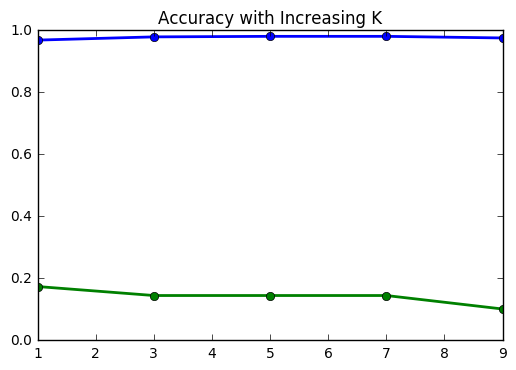

In [78]:
plt.rc("lines", lw=2, marker='o')

pl.plot(results.n, results.accuracy)
pl.plot(results.n, results.recall)
pl.ylim([0,1])
pl.title("Accuracy with Increasing K")
pl.show()

#### Accuracy is good but recall is terrible.  Why?

**kNN is very sensitive to scaling of features.** Some features with the same units (such as $) may be best scaled in relation to the range of all features with those units, not just the range of that feature itself.  Other features may not need to be scaled at all.  For more information, refer here: [About Feature Scaling and Normalization](http://sebastianraschka.com/Articles/2014_about_feature_scaling.html)

**kNN requires all features to be categorical or all continuous.**  If we did want to encode categorical features (such as advertiser_id) in this model with the other continuous features, we might find a

